In [197]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from torch import nn
from d2l import torch as d2l
import time

In [250]:
# Obtain the file list
cur_path = os.getcwd()
parent = os.path.dirname(cur_path)
path = parent + '/Data'
os.chdir(path)
list_dir = os.listdir(path)

In [251]:
# Transfer the string to numpy array
def str2array(df, col_name):
    shape = {'lmList': (df.shape[0], 21, 3),
             'bbox': (df.shape[0], 4, 1),
             'center': (df.shape[0], 2, 1)        
    }
    df[col_name] = df[col_name].map(lambda x: eval(x))
    
    return np.concatenate(df[col_name]).reshape(shape[col_name])

In [252]:
# Put data into numpy arrays
files_csv = list(filter(lambda x:x[-4:] == '.csv',list_dir))
for i, file in enumerate(files_csv):
    df = pd.read_csv(file)
    if i == 0:
        np_lmList = str2array(df, 'lmList')
        np_bbox = str2array(df, 'bbox')
        np_center = str2array(df, 'center')
        np_type = np.array([file[0]]).repeat(df.shape[0])
        np_num = np.array([int(file[-5])]).repeat(df.shape[0]) 
    else:
        np_lmList = np.concatenate((np_lmList, str2array(df, 'lmList')), axis=0)
        np_bbox = np.concatenate((np_bbox, str2array(df, 'bbox')), axis=0)
        np_center = np.concatenate((np_center, str2array(df, 'center')), axis=0)
        np_type = np.concatenate((np_type, np.array([file[0]]).repeat(df.shape[0])))
        np_num = np.concatenate((np_num, np.array([int(file[-5])]).repeat(df.shape[0])))

In [253]:
def nomilization(lmList, bbox, center):
    lmList = lmList.astype(np.float32)
    lmList[:, :, 0] = (lmList[:, :, 0] - center[:, 0]) / bbox[:, 2]
    lmList[:, :, 1] = (lmList[:, :, 1] - center[:, 1]) / bbox[:, 3]
    return lmList

In [254]:
np_lmList = nomilization(np_lmList, np_bbox, np_center)

In [255]:
index_left = np.where(np_type == 'l')
index_right = np.where(np_type == 'r')
np_lmList_left = np_lmList[index_left]
np_num_left = np_num[index_left]
np_lmList_right = np_lmList[index_right]
np_num_right = np_num[index_right]

In [256]:
index = np.arange(0, np_lmList_left.shape[0])
np.random.shuffle(index)
np_lmList_left = np_lmList_left[index]
np_num_left = np_num_left[index]
np_lmList_right = np_lmList_right[index]
np_num_right = np_num_right[index]

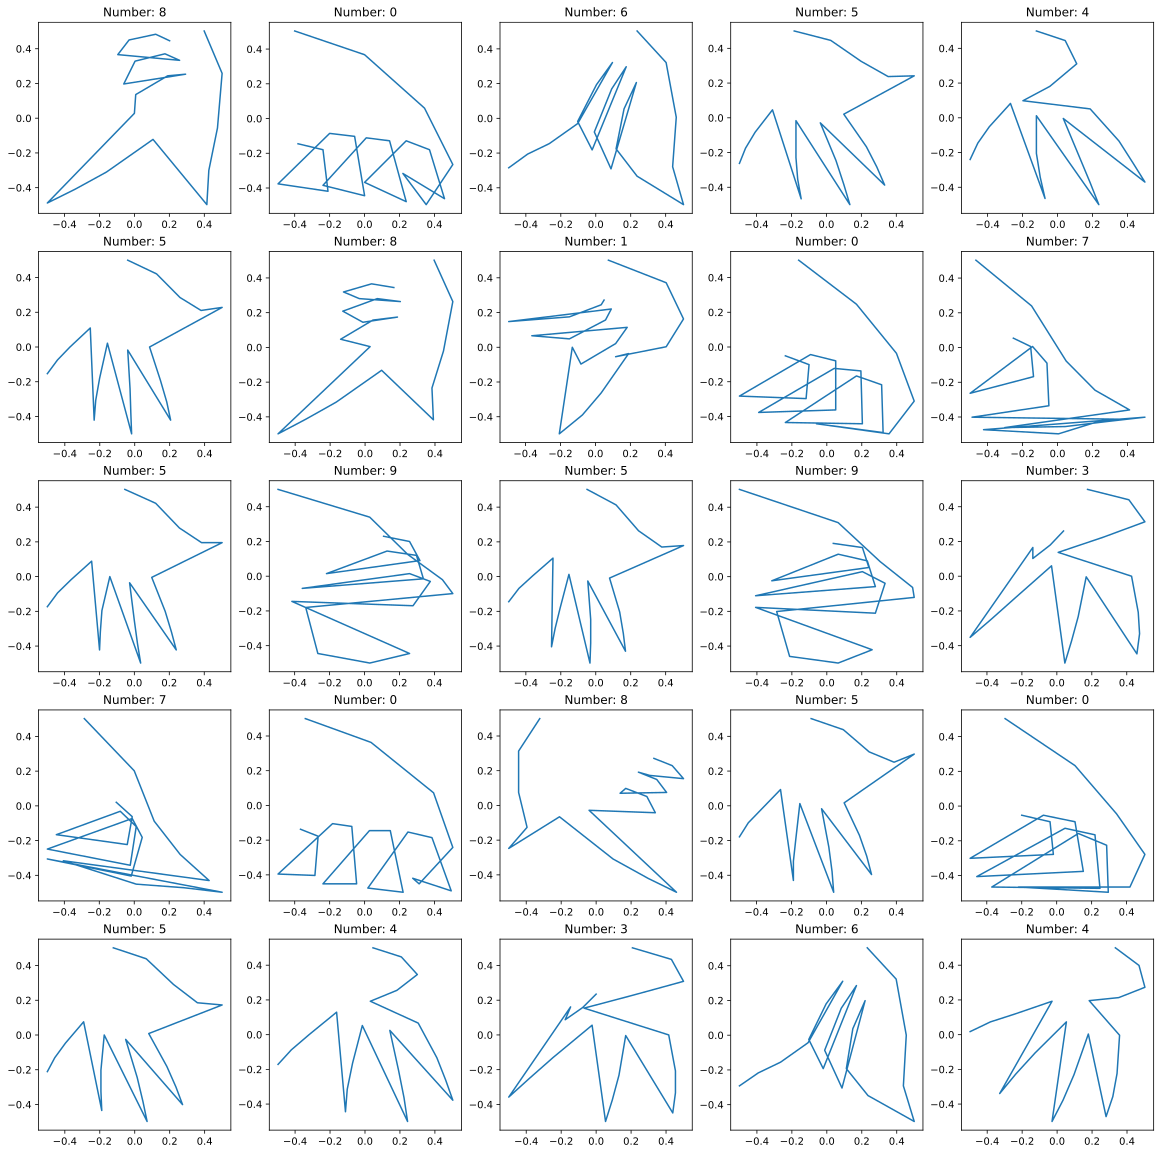

In [257]:
n_row = 5
n_col = 5
fig, axes = plt.subplots(n_row, n_col, figsize=(20, 20))
for i in range(n_row):
  for j in range(n_col):
    axes[i][j].plot(np_lmList_left[n_col*i+j, :, 0], np_lmList_left[n_col*i+j, :, 1])
    axes[i][j].set_title(f'Number: {np_num_left[n_col*i+j]}')
plt.show()

In [258]:
np_num_left = pd.get_dummies(np_num_left).values
np_num_right = pd.get_dummies(np_num_right).values

In [259]:
np_lmList_left = np_lmList_left.transpose(0, 2, 1)
np_lmList_right = np_lmList_right.transpose(0, 2, 1)

In [260]:
threshold = int(0.8*np_lmList_left.shape[0])
np_X_train_left = np_lmList_left[:threshold]
np_Y_train_left = np_num_left[:threshold]
np_X_valid_left = np_lmList_left[threshold:]
np_Y_valid_left = np_num_left[threshold:]

In [261]:
np_X_train_right = np_lmList_right[:threshold]
np_Y_train_right = np_num_right[:threshold]
np_X_valid_right = np_lmList_right[threshold:]
np_Y_valid_right = np_num_right[threshold:]

In [262]:
X_train_left = torch.tensor(np_X_train_left, dtype=torch.float32)
Y_train_left = torch.tensor(np_Y_train_left, dtype=torch.float32)
X_valid_left = torch.tensor(np_X_valid_left, dtype=torch.float32)
Y_valid_left = torch.tensor(np_Y_valid_left, dtype=torch.float32)

In [263]:
X_train_right = torch.tensor(np_X_train_right, dtype=torch.float32)
Y_train_right = torch.tensor(np_Y_train_right, dtype=torch.float32)
X_valid_right = torch.tensor(np_X_valid_right, dtype=torch.float32)
Y_valid_right = torch.tensor(np_Y_valid_right, dtype=torch.float32)

In [264]:
net_left = nn.Sequential(
        nn.Conv1d(3, 6, kernel_size=5, stride=2, padding=2), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        nn.Conv1d(6, 16, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

In [265]:
net_right = nn.Sequential(
        nn.Conv1d(3, 6, kernel_size=5, stride=2, padding=2), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        nn.Conv1d(6, 16, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

In [266]:
X = torch.rand(size=(1, 3, 21), dtype=torch.float32)
for layer in net_left:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv1d output shape: 	 torch.Size([1, 6, 11])
ReLU output shape: 	 torch.Size([1, 6, 11])
MaxPool1d output shape: 	 torch.Size([1, 6, 5])
Conv1d output shape: 	 torch.Size([1, 16, 5])
ReLU output shape: 	 torch.Size([1, 16, 5])
MaxPool2d output shape: 	 torch.Size([1, 8, 2])
Flatten output shape: 	 torch.Size([1, 16])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [267]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [268]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 20, 1e-3, 0, 64, try_gpu()

loss 0.013, train acc 0.997, valid acc 0.996
8482.8 examples/sec on cuda:0


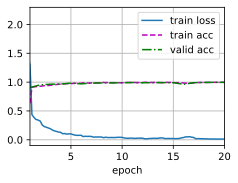

In [269]:
train_accuracy(net_left, X_train_left, Y_train_left, X_valid_left, Y_valid_left, num_epochs, lr, weight_decay, batch_size, device)

loss 0.012, train acc 0.996, valid acc 0.994
7348.2 examples/sec on cuda:0


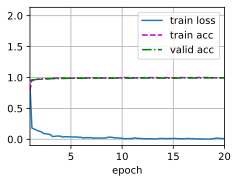

In [272]:
train_accuracy(net_right, X_train_right, Y_train_right, X_valid_right, Y_valid_right, num_epochs, lr, weight_decay, batch_size, device)

In [271]:
torch.save(net_left, 'net_left.pkl')
torch.save(net_right, 'net_right.pkl')